<a href="https://colab.research.google.com/github/parulnith/Demo1/blob/master/Sensitivity_Analysis_for_XGBoost_Adversarial_Example_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 8: Debugging XGBoost

### Sensitivity Analysis for XGBoost - Adversarial Example Search

We’ll apply an adversarial examples search as our next debugging technique. The goal
of our search is two-fold. 
1. To find adversarial examples that could be used to trick
our model once it’s deployed, and 
2. to see what we can learn about our model —
good and bad — as a result of our search

## Setting the Environment

Download the [zipped **data_and_package** folder](https://github.com/ml-for-high-risk-apps-book/Machine-Learning-for-High-Risk-Applications-Book/blob/main/code/data_and_package.zip) onto your local system and save it as `Data.zip`. 

In [7]:
# Upload the downloaded zipped file from your system to the colab environment. 
from google.colab import files
uploaded = files.upload()

In [2]:
!unzip -q "/content/Data.zip" 
%cd /content/Data

replace __MACOSX/._Data? [y]es, [n]o, [A]ll, [N]one, [r]ename: /content/Data


In [12]:
# Installing the libraries
%pip install shap
%pip install 'XGBoost==1.6'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Global hyperpameters

In [4]:
SEED = 12345 # global random seed for better reproducibility

### Python imports and inits

In [14]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np                        # array, vector, matrix calculations
import pandas as pd                       # DataFrame handling
import shap                               # for consistent, signed variable importance measurements
import xgboost as xgb                     # gradient boosting machines (GBMs)

from itertools import combinations        # n choose k combinations of objects
import string                             # for operations on character strings

pd.options.display.max_columns = 999      # enable display of all DataFrame columns in notebook

import matplotlib.pyplot as plt           # general plotting utilities
from mpl_toolkits.mplot3d import Axes3D   # for 3-D projections
from matplotlib import cm                 # colormaps for plots


# set numpy random seed
np.random.seed(SEED)

### Importing dataset 

In [15]:
path = '../Data/Data/credit_line_increase.csv'
data = pd.read_csv(path) 
data.head()

,ID,LIMIT_BAL,SEX,RACE,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DELINQ_NEXT
0,1,20000,2,1.0,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2.0,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,3.0,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,4.0,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,3.0,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


#### Assign target and inputs for models
Note that Demographic features are not used as model inputs.

In [16]:
# assign target and inputs for GBM
y = 'DELINQ_NEXT'
X = [name for name in data.columns if name not in [y, 'ID', 'SEX', 'RACE', 'EDUCATION', 'MARRIAGE', 'AGE']]
print('y =', y)
print('X =', X)

y = DELINQ_NEXT
X = ['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


Split data into training and test sets for early stopping

In [9]:
np.random.seed(SEED)

split_train_test = 2/3

split = np.random.rand(len(data)) < split_train_test
train = data[split].copy()
test = data[~split].copy()

split_test_valid = 1/2

split = np.random.rand(len(test)) < split_test_valid
valid = test[split].copy()
test = test[~split].copy()

del data

print(f"Train/Validation/Test sizes: {len(train)}/{len(valid)}/{len(test)}")

Train/Validation/Test sizes: 19919/5045/5036


## Train XGBoost GBM classifier

In [17]:
# XGBoost uses SVMLight data structure, not Numpy arrays or Pandas DataFrames 
dtrain = xgb.DMatrix(train[X], train[y])
dvalid = xgb.DMatrix(valid[X], valid[y])

# used to calibrate predictions to mean of y 
base_y = train[y].mean()

# tuning parameters
params = {
  "booster": "gbtree",
  "colsample_bytree": 0.7,
  "eta": 0.05,
  "max_depth": 5,
  "objective": "binary:logistic",
  "reg_alpha": 0.0005,
  "reg_lambda": 0.0005,
  "seed": 12345,
  "subsample": 0.5,
  "nthread": 16,
  "base_score": 0.22029218334253728,
  "monotone_constraints": {
    "LIMIT_BAL": -1,
    "PAY_0": 1,
    "PAY_2": 1,
    "PAY_3": 1,
    "PAY_4": 1,
    "PAY_5": 1,
    "PAY_6": 1,
    "BILL_AMT1": -1,
    "BILL_AMT2": -1,
    "BILL_AMT3": -1,
    "BILL_AMT4": -1,
    "BILL_AMT5": -1,
    "BILL_AMT6": -1,
    "PAY_AMT1": -1,
    "PAY_AMT2": -1,
    "PAY_AMT3": -1,
    "PAY_AMT4": -1,
    "PAY_AMT5": -1,
    "PAY_AMT6": -1
  },
  "eval_metric": "auc",
  "seed": SEED  
}

# watchlist is used for early stopping
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

# train model
xgb_model = xgb.train(params,                   # set tuning parameters from above                   
                      dtrain,                   # training data
                      1000,                     # train up to 5000 iterations
                      evals=watchlist,          # use watchlist for early stopping 
                      early_stopping_rounds=50, # stop after 50 rounds of no increase in AUC in test set 
                      verbose_eval=True)        # display iteration progress

print('\nBest training AUC: %.6f at iteration: %i.' % (xgb_model.best_score, xgb_model.best_iteration))

[0]	train-auc:0.70324	eval-auc:0.70267
[1]	train-auc:0.77079	eval-auc:0.76721
[2]	train-auc:0.77224	eval-auc:0.76663
[3]	train-auc:0.76977	eval-auc:0.76489
[4]	train-auc:0.76781	eval-auc:0.76245
[5]	train-auc:0.77274	eval-auc:0.76895
[6]	train-auc:0.77504	eval-auc:0.77176
[7]	train-auc:0.77520	eval-auc:0.77286
[8]	train-auc:0.77523	eval-auc:0.77270
[9]	train-auc:0.77526	eval-auc:0.77284
[10]	train-auc:0.77559	eval-auc:0.77330
[11]	train-auc:0.77596	eval-auc:0.77335
[12]	train-auc:0.77676	eval-auc:0.77345
[13]	train-auc:0.77664	eval-auc:0.77352
[14]	train-auc:0.77660	eval-auc:0.77373
[15]	train-auc:0.77667	eval-auc:0.77367
[16]	train-auc:0.77707	eval-auc:0.77363
[17]	train-auc:0.77734	eval-auc:0.77354
[18]	train-auc:0.77724	eval-auc:0.77335
[19]	train-auc:0.77744	eval-auc:0.77379
[20]	train-auc:0.77742	eval-auc:0.77416
[21]	train-auc:0.77741	eval-auc:0.77447
[22]	train-auc:0.77753	eval-auc:0.77453
[23]	train-auc:0.77748	eval-auc:0.77458
[24]	train-auc:0.77776	eval-auc:0.77466
[25]	train

## SHAP Feature importance

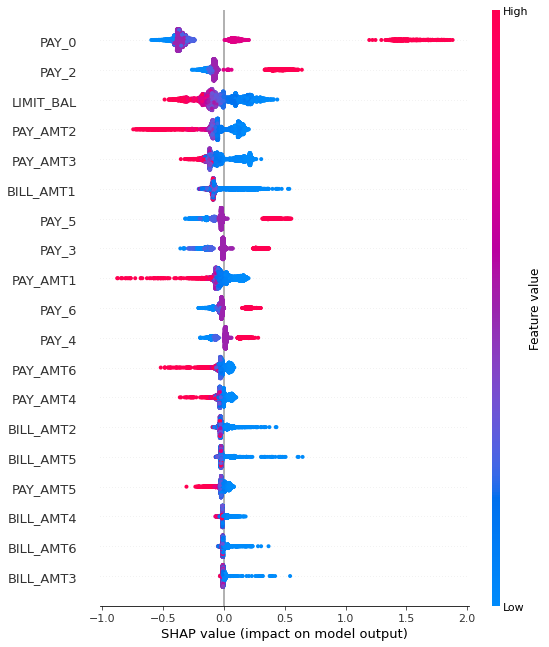

In [18]:
shap_values = xgb_model.predict(dvalid, pred_contribs=True, iteration_range=(0, xgb_model.best_iteration))
shap.summary_plot(shap_values[:, :-1], valid[xgb_model.feature_names])

## Calculating partial dependence, its residuals, and ICE

In [23]:
def par_dep(xs, frame, model, y=None, resid=False, abs_=False, resolution=20,
            bins=None):
    
    """ Calculates partial dependence and residuals of partial dependence.

    Args:
        xs: Variable for which to calculate partial dependence or its residuals.
        frame: Pandas DataFrame for which to calculate partial dependence or 
               its residuals.
        model: XGBoost model for which to calculate partial dependence or 
               its residuals.
        y: Name of original target variable.   
        resid: Return residuals of partial dependence instead of partial 
               dependence, default False.
        abs_: Return unsigned, absolute residuals, default False.
              (Good for handling both classes in logloss simultaneously.)
        resolution: The number of points across the domain of xs for which 
                    to calculate partial dependence or its residuals, default 20.
        bins: List of values at which to set xs, default 20 equally-spaced 
              points between column minimum and maximum.
    
    Returns: Pandas DataFrame containing partial dependence or its residual 
             values at bins.
        
    """
    
    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None
    
    # initialize empty Pandas DataFrame with correct column names
    return_frame = pd.DataFrame(columns=[xs,'residual'])
    
    # cache original column values 
    col_cache = frame.loc[:, xs].copy(deep=True)
  
    # determine values at which to calculate partial dependence
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        # modify max and by 
        # to preserve resolution and actually search up to max
        bins = np.arange(min_, (max_ + by), (by + np.round((1. / resolution) * by, 3)))
        
    # residuals of partial dependence
    if resid:        
        
        # initialize empty Pandas DataFrame with correct column names
        return_frame = pd.DataFrame(columns=[xs,'residual'])
        
        for j in bins:

            # frame to cache intermediate results
            rframe_ = pd.DataFrame(columns=['actual', 'pred',  'res'])

            frame.loc[:, xs] = j 
            dframe = xgb.DMatrix(frame.drop(y, axis=1)) 
            # reset index for expected merge behavior
            rframe_['actual'] = frame[y].reset_index(drop=True)
            rframe_['pred'] = pd.DataFrame(model.predict(dframe,
                                                         iteration_range=(0, model.best_iteration)))
            # logloss residual
            rframe_['res'] = -rframe_['actual']*np.log(rframe_['pred']) -\
                             (1 - rframe_['actual'])*np.log(1 - rframe_['pred'])

            if abs_:
                # optionally return absolute value
                resid_j = np.abs(rframe_['res']).mean() 
            else:
                resid_j = rframe_['res'].mean()

            del rframe_            

            return_frame = return_frame.append({xs:j,
                                               'residual': resid_j}, 
                                               ignore_index=True)
            
    # partial dependence  
    else:   
        
        # initialize empty Pandas DataFrame with correct column names
        return_frame = pd.DataFrame(columns=[xs, 'partial_dependence'])
        
        for j in bins:
            frame.loc[:, xs] = j
            dframe = xgb.DMatrix(frame)
            par_dep_i = pd.DataFrame(model.predict(dframe, 
                                                   iteration_range=(0, model.best_iteration)))
            par_dep_j = par_dep_i.mean()[0]
            return_frame = return_frame.append({xs:j,
                                               'partial_dependence': par_dep_j}, 
                                               ignore_index=True)
           
    # return input frame to original cached state    
    frame.loc[:, xs] = col_cache

    return return_frame


#### Establish out-of-range and missing bins for partial dependence and ICE

In [24]:
bins = [np.nan, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0]

#### Calculate partial dependence and its residuals for the most important input variable in the GBM

In [25]:
# calculate partial dependence
par_dep_PAY_0 = par_dep('PAY_0', test[X], xgb_model, bins=bins)

# calculate both classes of residuals on the same bins as above
bins = list(par_dep_PAY_0['PAY_0'])

# 0
par_dep_PAY_0['residual_0'] = par_dep('PAY_0', test.loc[test[y] == 0, X + [y]], 
                                      xgb_model, y=y, resid=True, 
                                      bins=bins)['residual'] 

# 1
par_dep_PAY_0['residual_1'] = par_dep('PAY_0', test.loc[test[y] == 1, X + [y]], 
                                      xgb_model, y=y, resid=True, 
                                      bins=bins)['residual'] 

par_dep_PAY_0

,PAY_0,partial_dependence,residual_0,residual_1
0,NaN,0.156675,0.149972,1.627750
1,-2.0,0.156675,0.149972,1.627750
2,-1.5,0.174938,0.170908,1.515059
3,-1.0,0.174938,0.170908,1.515059
4,-0.5,0.175666,0.171764,1.510396
5,0.0,0.175666,0.171764,1.510396
6,0.5,0.230263,0.237838,1.242203
7,1.0,0.230263,0.237838,1.242203
8,1.5,0.526767,0.740556,0.515328
9,2.0,0.526767,0.740556,0.515328


#### Helper function for finding percentiles of predictions

In [26]:
def get_percentile_dict(sort_var, id_, frame):

    """ Returns the percentiles of a column, sort_var, as the indices based on 
        another column id_.
    
    Args:
        sort_var: Column in which to find percentiles.
        id_: Row id, column that stores indices for percentiles of yhat.
        frame: Pandas DataFrame containing sort_var and id_. 
    
    Returns:
        Dictionary of percentile values and index column values.
    
    """
    
    # create a copy of frame and sort it by sort_var
    sort_df = frame.copy(deep=True)
    sort_df.sort_values(sort_var, inplace=True)
    sort_df.reset_index(inplace=True)
    
    # find top and bottom percentiles
    percentiles_dict = {}
    percentiles_dict[0] = sort_df.loc[0, id_]
    percentiles_dict[99] = sort_df.loc[sort_df.shape[0]-1, id_]

    # find 10th-90th percentiles
    inc = sort_df.shape[0]//10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc,  id_]

    return percentiles_dict


#### Find some percentiles of `p_DEFAULT_NEXT_MONTH`  in the test data

In [27]:
# merge GBM predictions and residuals onto test data
yhat = 'p_DEFAULT_NEXT_MONTH'
resid = 'r_DEFAULT_NEXT_MONTH' # residuals for use in section 5
yhat_valid = pd.concat([valid.reset_index(drop=True), pd.DataFrame(xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration)))], axis=1)
yhat_valid = yhat_valid.rename(columns={0: yhat})
yhat_valid[resid] = -yhat_valid[y]*np.log(yhat_valid[yhat]) -\
                             (1 - yhat_valid[y])*np.log(1 - yhat_valid[yhat]) # logloss

# find percentiles of predictions
yhat_percentile_dict = get_percentile_dict(yhat, 'ID', yhat_valid)

# display percentiles dictionary
# ID values for rows
# from lowest prediction 
# to highest prediction
yhat_percentile_dict

{0: 23477,
 99: 20904,
 10: 27181,
 20: 20186,
 30: 22227,
 40: 9059,
 50: 4655,
 60: 18910,
 70: 26919,
 80: 9906,
 90: 12489}

#### Calculate ICE curve values

In [28]:
# retreive bins from partial dependence calculation
bins_PAY_0 = list(par_dep_PAY_0['PAY_0']) 

# for each percentile in percentile_dict
# create a new column in the par_dep frame 
# representing the ICE curve for that percentile
# and the variable of interest, PAY_0
for i in sorted(yhat_percentile_dict.keys()):
    
    col_name = 'Percentile_' + str(i)
    
    # ICE curves for PAY_0 across percentiles at bins_PAY_0 intervals
    par_dep_PAY_0[col_name] = par_dep('PAY_0', 
                                    valid[valid['ID'] == int(yhat_percentile_dict[i])][X],  
                                    xgb_model, 
                                    bins=bins_PAY_0)['partial_dependence']    

par_dep_PAY_0.head(n=5)

,PAY_0,partial_dependence,residual_0,residual_1,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,NaN,0.156675,0.149972,1.627750,0.003201,0.065620,0.066205,0.097828,0.101410,0.127041,0.169118,0.199730,0.251565,0.545406,0.786901
1,-2.0,0.156675,0.149972,1.627750,0.003201,0.065620,0.066205,0.097828,0.101410,0.127041,0.169118,0.199730,0.251565,0.545406,0.786901
2,-1.5,0.174938,0.170908,1.515059,0.004096,0.073806,0.082522,0.107988,0.125073,0.151040,0.186081,0.231564,0.262008,0.572124,0.798071
3,-1.0,0.174938,0.170908,1.515059,0.004096,0.073806,0.082522,0.107988,0.125073,0.151040,0.186081,0.231564,0.262008,0.572124,0.798071
4,-0.5,0.175666,0.171764,1.510396,0.004546,0.073806,0.083411,0.107988,0.125073,0.151040,0.186081,0.231932,0.262625,0.572630,0.798404


#### Helper function to plot partial dependence and ICE

In [29]:
def plot_par_dep_ICE(xs, par_dep_frame, ax=None, ticks=None, labels=None):

    
    """ Plots ICE overlayed onto partial dependence for a single variable.
    Conditionally uses user-defined axes, ticks, and labels for grouped subplots.
    
    Args: 
        xs: Name of variable for which to plot ICE and partial dependence.
        par_dep_frame: Name of Pandas DataFrame containing ICE and partial
                       dependence values.
        ax: Matplotlib axis object to use, default None.         
        ticks: List of numeric x-axis tick marks, default None.  
        labels: List of string values to use as the visual label for ticks, 
                default None. 
    
    """
    
    # initialize figure and axis for grouped subplots 
    if (ticks is None) & (labels is None) & (ax is None):
        pass
    else:
        _ = ax.set(xticks=ticks, xticklabels=labels) # user-defined 
    
    # for standalone plotting
    if ax is None:
        
        # initialize figure and axis
        fig, ax = plt.subplots()
        
        # plot ICE
        par_dep_frame.drop('partial_dependence', axis=1).plot(x=xs, 
                                                              colormap='coolwarm', 
                                                              ax=ax)
        # overlay partial dependence, annotate plot
        par_dep_frame.plot(title='Partial Dependence with ICE',
                           x=xs, 
                           y='partial_dependence',
                           color='grey', 
                           linewidth=3, 
                           ax=ax)
    
    # for grouped subplots 
    else: 
        
        # plot ICE
        par_dep_frame.drop('partial_dependence', axis=1).plot(x=xs, 
                                                              colormap='coolwarm',
                                                              ax=ax)
        # overlay partial dependence, annotate plot
        par_dep_frame.plot(title='Partial Dependence with ICE',
                           x=xs, 
                           y='partial_dependence',
                           color='grey', 
                           linewidth=3, 
                           ax=ax)

    # add legend
    _ = plt.legend(bbox_to_anchor=(1.05, 0),
                   loc=3, 
                   borderaxespad=0.)


#### Plot partial dependence, its residuals, and ICE along with a histogram of `PAY_0` grouped by target class

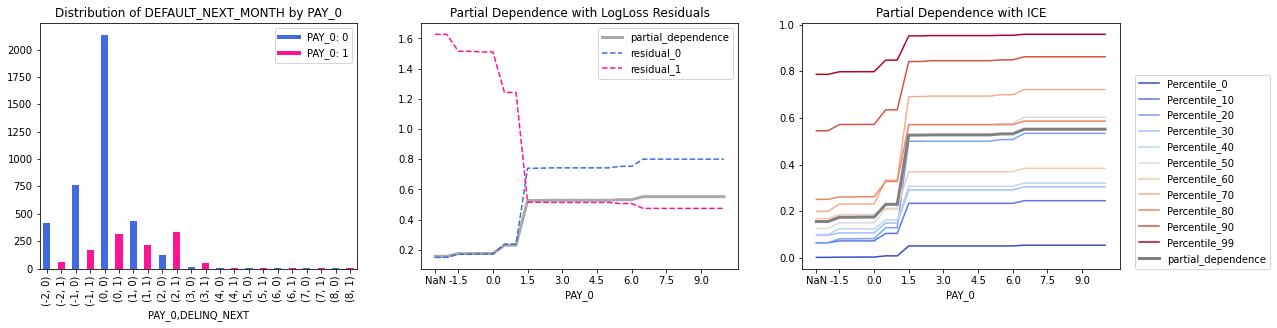

In [30]:
# setup ########################################################################

# tricks to have NaN appear on the x-axis
par_dep_PAY_0.iloc[0, 0] = -2.5
ticks = [-2.5] + list(par_dep_PAY_0['PAY_0'])[2:][::3]
labels = ['NaN'] + list(par_dep_PAY_0['PAY_0'])[2:][::3]

# setup 3-way figure
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=False)
plt.tight_layout()
plt.subplots_adjust(left=0.0, right=2.5, wspace=0.2)
   
# histogram grouped by target class for PAY_0 ##################################

from matplotlib.lines import Line2D # custom legend
custom_lines = [Line2D([0], [0], color='royalblue', lw=4),
                Line2D([0], [0], color='deeppink', lw=4)]

# establish groups and plot w/ custom legend
_ = valid.groupby(['PAY_0', y]).count().plot(kind='bar', y='ID', legend=False, 
                                            color=['royalblue', 'deeppink']*10, 
                                            title='Distribution of DEFAULT_NEXT_MONTH by PAY_0', 
                                            ax=ax0)
_ = ax0.legend(custom_lines, ['PAY_0: 0', 'PAY_0: 1'])
 
# partial dependence and residuals #############################################

_ = ax1.set(xticks=ticks, xticklabels=labels)
_ = par_dep_PAY_0.plot(kind='line', x='PAY_0', y='partial_dependence', 
                       color='darkgrey', linewidth=3,
                       title='Partial Dependence with LogLoss Residuals', 
                       ax=ax1)
_ = par_dep_PAY_0.plot(kind='line', x='PAY_0', y='residual_0', color='royalblue', 
                       linestyle='--', ax=ax1)
_ = par_dep_PAY_0.plot(kind='line', x='PAY_0', y='residual_1', color='deeppink', 
                       linestyle='--', ax=ax1)

# partial dependence and ICE ###################################################

plot_par_dep_ICE('PAY_0', par_dep_PAY_0.drop(['residual_0', 'residual_1'], 
                                             axis=1), 
                  ax2, ticks, labels)

# Adversarial Examples 

#### Conduct adversarial example search over important variables for an interesting row.
In the ICE plot above, the customer at the 80th percentile of predicted probability of default was shown to have a high degree of variability in their predictions across the values of `PAY_0`. The row will serve as a prototype in a search for adversarial examples.

#### The original row, used as prototype 
For reference, the values for each variable in the prototype row are displayed.

In [31]:
yhat_valid[yhat_valid['ID'] == yhat_percentile_dict[80]]

,ID,LIMIT_BAL,SEX,RACE,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DELINQ_NEXT,p_DEFAULT_NEXT_MONTH,r_DEFAULT_NEXT_MONTH
1660,9906,500000,2,4.0,1,2,39,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.328154,0.397726


#### Function to find adversarial examples
The search for adversarial examples takes a prototype row, perturbs the values of certain variables in the row, and records the new prediction and residual for each new perturbed row. 

In [32]:
def find_adversaries(xs, frame, model, row_id, oor_proportion=0.1, 
                     resolution=10, verbose=False):  
    
    """ A brute force function to find adversaries. Dynamically generates nested loops
        to populate adversary_frame with perturbed values and their predictions
        and logloss residuals.
        
        ASSUMES global vars y, yhat, and resid have been defined previously.
        
    Args:    
        xs: List of variables over which to find adversaries.
        frame: Pandas DataFrame for which to calculate bounds for adversary search.
               row_id is assumed to be in frame.
        model: Model to use in adversary search.
        row_id: Prototype row on which the search is based.
        oor_proportion: The proportion by which the search can exceed minimum and 
                        maximum values in frame. Must be between 0-1, default 0.1.
        resolution: The number of points across the domain of xs for which 
                    to search for adversaries, default 10 due to deep nesting.
        verbose: Boolean, whether to print generated code statements.
                
    Returns: 
        Frame containing all tested values and their associated predictions 
        and logloss residuals. 
    
    """
    
    # init dicts to hold bin values
    bins_dict = {}
    
    # find boundaries, bins and record 
    for j in xs:
        
        min_ = frame[j].min()
        max_ = frame[j].max()
        min_ = min_ - np.abs(oor_proportion*min_)
        max_ = max_ + np.abs(oor_proportion*max_)
        by = (max_ - min_)/resolution
        # modify max and by 
        # to preserve resolution and actually search up to max
        bins_dict[j] = np.arange(min_, (max_ + by), (by + np.round((1. / resolution) * by, 3)))
        bins_dict[j] = np.round_(bins_dict[j], 6)  # reasonable precision
    
    # initialize prototype row
    # deep copy to prevent corruption of original data
    row = frame[frame['ID'] == row_id].copy(deep=True)
    
    # generate nested loops dynamically ############################################
    # to search all vals in all search cols
    
    # init true tab
    # define code variable and init returned Pandas DataFrame, adversary_frame
    tab = '    '
    code = 'global adversary_frame\n'
    code += 'adversary_frame = pd.DataFrame(columns=xs + [yhat])\n'

    # generate for loop statements for search
    for i, j in enumerate(xs):
        code += i*tab + 'for ' + string.ascii_lowercase[i] + ' in ' +\
            str(list(bins_dict[j])) + ':\n'
            
    # generate value assignment statements to perturb search vars
    for k, j in enumerate(xs):
        code += (i + 1)*tab + 'row["' + j + '"] = ' + string.ascii_lowercase[k] +\
            '\n'
    
    # generate progress reporting statements  
    # generate statements for appending test values, preds, and resids to adversary_frame
    # uses only absolute residuals to avoid averaging problems between 0/1 target classes
    code += (i + 1)*tab + 'if (adversary_frame.shape[0] + 1) % 1000 == 0:\n'
    code += (i + 2)*tab +\
        'print("Built %i/%i rows ..." % (adversary_frame.shape[0] + 1, (resolution)**(i+1)))\n'
    code += (i + 1)*tab +\
        'adversary_frame = adversary_frame.append(row, ignore_index=True, sort=False)\n' 
    code += 'adversary_frame[search_cols] = adversary_frame[search_cols].astype(float, errors = "raise")\n'
    code += 'print("Scoring ...")\n'
    code += 'adversary_frame[yhat] = model.predict(xgb.DMatrix(adversary_frame[model.feature_names]), iteration_range=(0, model.best_iteration))\n'
    code += 'print("Done.")'
    
    if verbose:
        print('Executing:')
        print(code)
        print('--------------------------------------------------------------------------------')
    
    # execute generated code
    exec(code)
    
    return adversary_frame


In [ ]:
res_ = 10 # keep resolution small to avoid long run time

# four variables with widest Shapley contribs -- see figure above
search_cols = ['PAY_0', 'PAY_2', 'PAY_AMT1', 'PAY_AMT2'] 

# execute search
yhat_adversaries = find_adversaries(search_cols, valid, xgb_model, yhat_percentile_dict[80], resolution=res_, verbose=True)

Executing:
global adversary_frame
adversary_frame = pd.DataFrame(columns=xs + [yhat])
for a in [-2.2, -0.99, 0.22, 1.43, 2.64, 3.85, 5.06, 6.27, 7.48, 8.69]:
    for b in [-2.2, -1.111, -0.022, 1.067, 2.156, 3.245, 4.334, 5.423, 6.512, 7.601]:
        for c in [0.0, 105699.792, 211399.584, 317099.376, 422799.168, 528498.96, 634198.752, 739898.544, 845598.336, 951298.128]:
            for d in [0.0, 147071.991, 294143.982, 441215.973, 588287.964, 735359.955, 882431.946, 1029503.937, 1176575.928, 1323647.919]:
                row["PAY_0"] = a
                row["PAY_2"] = b
                row["PAY_AMT1"] = c
                row["PAY_AMT2"] = d
                if (adversary_frame.shape[0] + 1) % 1000 == 0:
                    print("Built %i/%i rows ..." % (adversary_frame.shape[0] + 1, (resolution)**(i+1)))
                adversary_frame = adversary_frame.append(row, ignore_index=True, sort=False)
adversary_frame[search_cols] = adversary_frame[search_cols].astype(float, errors = "rais

#### Adversarial examples that minimize model predictions

In [ ]:
yhat_adversaries.sort_values(by=yhat).head(n=3)

,PAY_0,PAY_2,PAY_AMT1,PAY_AMT2,p_DEFAULT_NEXT_MONTH,ID,LIMIT_BAL,SEX,RACE,EDUCATION,MARRIAGE,AGE,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DELINQ_NEXT
96,-2.2,-2.2,951298.128,882431.946,0.049231,9906.0,500000.0,2.0,4.0,1.0,2.0,39.0,-2.0,-2.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72,-2.2,-2.2,739898.544,294143.982,0.049231,9906.0,500000.0,2.0,4.0,1.0,2.0,39.0,-2.0,-2.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71,-2.2,-2.2,739898.544,147071.991,0.049231,9906.0,500000.0,2.0,4.0,1.0,2.0,39.0,-2.0,-2.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Adversarial examples that maximize model predictions

In [ ]:
yhat_adversaries.sort_values(by=yhat).tail(n=3)

,PAY_0,PAY_2,PAY_AMT1,PAY_AMT2,p_DEFAULT_NEXT_MONTH,ID,LIMIT_BAL,SEX,RACE,EDUCATION,MARRIAGE,AGE,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DELINQ_NEXT
8800,7.48,6.512,0.0,0.0,0.69691,9906.0,500000.0,2.0,4.0,1.0,2.0,39.0,-2.0,-2.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9600,8.69,4.334,0.0,0.0,0.69691,9906.0,500000.0,2.0,4.0,1.0,2.0,39.0,-2.0,-2.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9800,8.69,6.512,0.0,0.0,0.69691,9906.0,500000.0,2.0,4.0,1.0,2.0,39.0,-2.0,-2.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Function for visual summary of adversary search results.
This function groups the DataFrame by two search variables and uses a custom descriptive statistic to summarize the group in terms of predictions or residuals. The summarized value is then plotted on a surface in terms of the two groupby variables. 

In [ ]:
def plot_sm_3d(frame, resolution, search_cols, z_axis_var, stat):

    """Plots 6 small multiples in a grouped subplot to display adversary search 
       results from find_adversaries.
    
    Args:
        frame: Pandas DataFrame containing potential adversaries generated by 
               find_adversaries.
        resolution: The number of points across the domain of the variables in 
                    search_cols in find_adversaries. 
        search_cols: List of search_cols used in find_adversaries.
        z_axis_var: The name of the variable by which to group the frame and
                    that will appear in the title and z-axis label of the 
                    generated plot.
        stat: Groupby stat for z_axis_var and frame.
    
    """
    
    max_ = frame[z_axis_var].max() # establish z-axis high limit
    
    fig = plt.figure(figsize=plt.figaspect(0.67)*2.5) # init 2 x 3 plot

    _2d_shape = (resolution, resolution) # correct shape for 3-D display of 1-D arrays

    # loop through 2-way combos of search_cols
    for i, two_way_combo in enumerate(list(combinations(search_cols, 2))):

        # many unique values exist for each 2-way combo of search_cols values 
        # summarize by stat to plot concisely
        
        # execute groupby
        groups = eval('frame[[two_way_combo[0], two_way_combo[1], z_axis_var]]\
                        .groupby([two_way_combo[0], two_way_combo[1]]).' + stat + '()')

        groups = groups.reset_index() # convert groupby vals to cols (from index)

        ax = fig.add_subplot(2, 3, (i + 1), projection='3d') # subplot placement
            
        # values and labels for each axis
        x = np.asarray(groups[two_way_combo[0]]).reshape(_2d_shape)
        ax.set_xlabel('\n' + two_way_combo[0])
        y = np.asarray(groups[two_way_combo[1]]).reshape(_2d_shape)
        ax.set_ylabel('\n' + two_way_combo[1])
        z = np.asarray(groups[z_axis_var]).reshape(_2d_shape)
        ax.set_zlabel('\n' + stat + ' ' + str(z_axis_var))
        ax.set_zlim3d(0, max_) # ensure constant scale
        
        # plot
        surf = ax.plot_surface(x, y, z, 
                               cmap=cm.coolwarm, 
                               linewidth=0.05, 
                               rstride=1, 
                               cstride=1, 
                               antialiased=True)
        
    
    # main title and display    
    fig.suptitle(stat.title() + ' ' + str(z_axis_var) + ' for ' + str(search_cols))    
    plt.tight_layout()
    _ = plt.show()
    

#### Maximum predictions across pairs of search variables
The plots below show the maximum model prediction generated by an adversary in terms of values of the search variables.

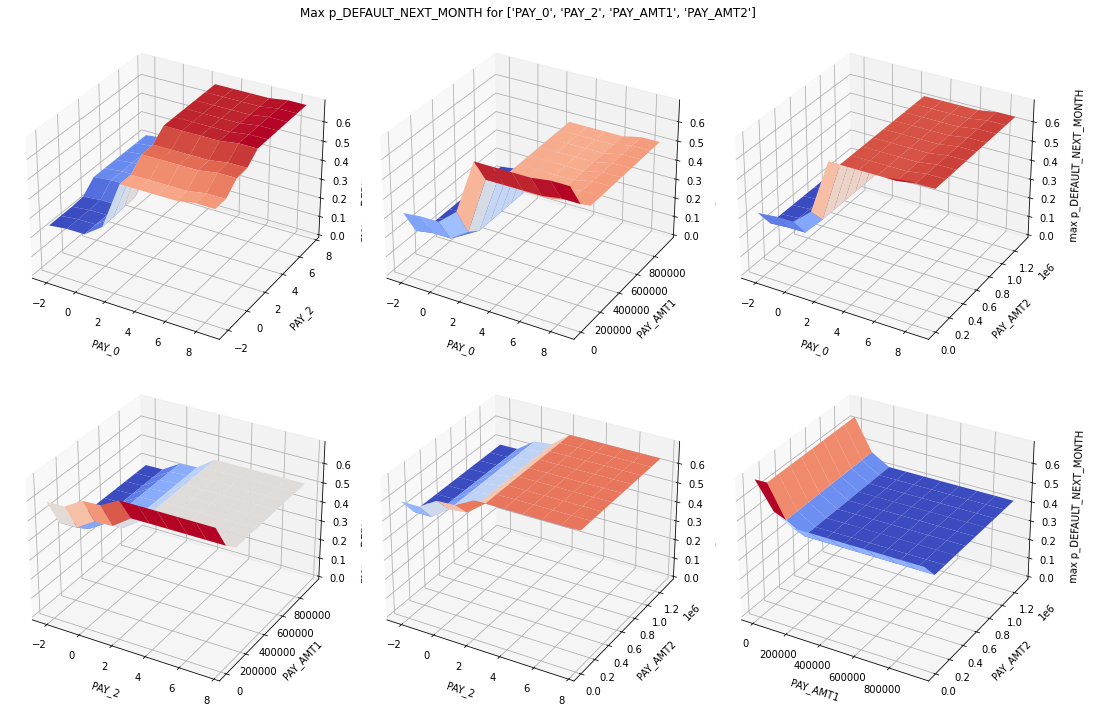

In [ ]:
plot_sm_3d(yhat_adversaries, res_, search_cols, yhat, 'max') # plot max prediction